<a href="https://colab.research.google.com/github/ApoorvaNagarajan/Image-Filter-Kernels/blob/master/assignment10/assignment10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing all python packages

In [0]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
# Import all the required python libraries

from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.utils import np_utils
import cv2
from keras.applications import VGG16
import scipy
from keras.preprocessing.image import load_img
from keras.preprocessing import image
import keras
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


# Load input image

In [0]:
!wget https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg
  
# load the image from file and resize it to 224x224
img = load_img('16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg', target_size=(224, 224))

--2019-07-21 11:25:39--  https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg
Resolving media.karousell.com (media.karousell.com)... 190.93.245.83, 190.93.244.83, 190.93.246.83, ...
Connecting to media.karousell.com (media.karousell.com)|190.93.245.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58670 (57K) [image/jpeg]
Saving to: ‘16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg’

16_scale_tony_stark 100%[===================>]  57.29K  --.-KB/s    in 0.001s  

2019-07-21 11:25:45 (41.6 MB/s) - ‘16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg’ saved [58670/58670]



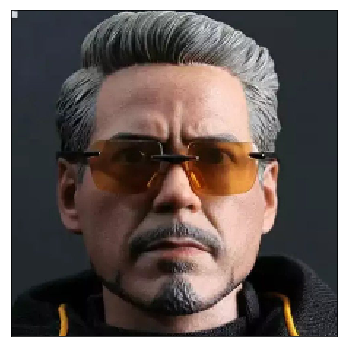

In [0]:
plt.rcParams['figure.figsize'] = (18, 6)
f, ax = plt.subplots(1, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(img)

# Load VGG model

In [0]:
# Build the VGG16 network with ImageNet weights
model = VGG16(weights='imagenet', include_top=True)

W0721 11:25:47.399792 140646159378304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0721 11:25:47.434945 140646159378304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0721 11:25:47.442839 140646159378304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0721 11:25:47.480154 140646159378304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



553467904/553467096 [==============================] - 42s 0us/step


W0721 11:26:31.183921 140646159378304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0721 11:26:31.185137 140646159378304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Apply GradCam to visualize the activations in layers

In [0]:
# grad cam function to visualize layers of a model

def gradCam(model, x, inputImg, layer, numCh, class_idx=-1):
  
  if(-1 == class_idx):
    preds = model.predict(x)
    class_idx = np.argmax(preds, axis=1)[0]
    
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer)
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(numCh):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (224, 224))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  heatmap = heatmap/255
  for i in range(len(heatmap)):
    for j in range(len(heatmap[0])):
      if heatmap[i][j][1]<=0.95 and heatmap[i][j][2]<=0.95:
        heatmap[i][j] = 0
  heatmap = np.uint8(255 * heatmap)
  img1 = np.uint8(image.img_to_array(inputImg))
  superimposed_img = cv2.addWeighted(img1, 0.6, heatmap, 0.4, 0)
  
  return(img1,superimposed_img)

In [0]:
# Apply the same pre processing as VGG network

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

Text(0.5, 1.0, 'Layer block5_conv3')

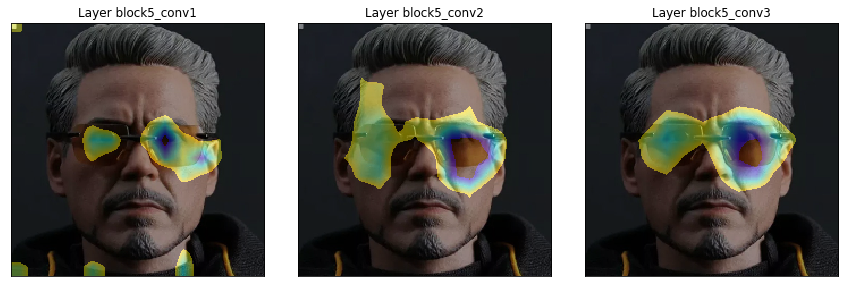

In [0]:
in_img1, sup_img1 = gradCam(model, x, img, "block5_conv1", 512, 837)
in_img2, sup_img2 = gradCam(model, x, img, "block5_conv2", 512, 837)
in_img3, sup_img3 = gradCam(model, x, img, "block5_conv3", 512, 837)


# Set up the display matix to display 25 images
fig, ax = plt.subplots(1, 3, figsize = (6, 6))
fig.tight_layout(pad = 0.3, rect = [0, 0, 2, 2])

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].imshow(sup_img1)
ax[0].set_title('Layer block5_conv1') 
    
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].imshow(sup_img2)
ax[1].set_title('Layer block5_conv2') 


ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].imshow(sup_img3)
ax[2].set_title('Layer block5_conv3') 
    

# Assignment 10B

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


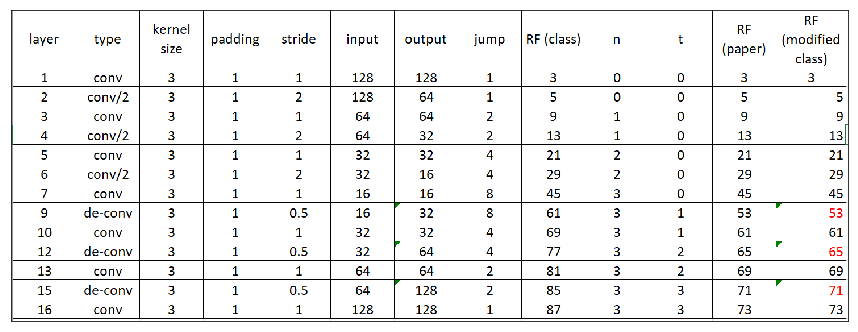

In [22]:
img2 = load_img('/content/drive/My Drive/input_images/assignment10.PNG')
f, ax = plt.subplots(1, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(img2)

**An increase in the receptive field from 29 to 45 is due to the convolution with stride 2. This halves the output size. This also multiplies the jump by 2. Hence receptive field jump** 

Table above uses the following formulae

RF(class) = Rin + (k-1)*Jin

RF(paper) = RFin + 2^(n-t)*(k-1)

RF(modified) = chnaged the RF calculation of de-conv layers only. According to the paper,  deconv layer upscales by 2 and then performs convolution. So modified the equation to
Rin + (k-1)*Jin/2